# Leonard Kramer Problem
This notebook is for the general audience. As so, some basic necessary process engineering concepts are briefly introduced for the sake of comprehension. If you are already familiar with these concepts, feel free to skip these explanatory sections. This notebook focuses on the machine learning analisys to solve this specific problem.
## Deep learning application to process engineering problems
The Leonard Kramer problem is a toy problem related to the fields of process fault identification and detection in the field of chemical processes. Proposed by [Leonard & Kramer, 1991](http://ieeexplore.ieee.org/document/75576/), it brings ease of visualization and a comprehensive parametric generation of patterns which closely approximates real life examples of process faults.

### Process industries
The chemical process industry is responsible to transform raw material into comercial products. Some examples of transformations are:

|Raw Material|Product|
|---|---|
|Oil|Gasoline,Diesel,Plastics|
|Starch,Yeast,Water|Beer,Wine,Spirits|
|Ore|Metals|
|Sulfur,Water|Sulfuric Acid|
|Fat,Soda|Soap|
|Vegetables|Sugar|
|Leaves,Fruits|Essencial oils|

In order to achieve these transformations in large scale and in a continuous/semi-continuous fashion, several industrial level equipment must be arranged in a complex manner. Some examples of industrial equipment are storage tanks, chemical reactors, distillation columns, heaters, coolers, furnaces, pressure vessels and so on. <br>
Now, in order yield a constant quality product, the industrial staff's main goal is to ensure that all conditions in all of the equipment remain constant, regardless of the external influences on the process. For the sake of generality, these conditions are called <b>process variables</b>. Some example of process variables are temperature, pressure, flow rate, density, concentration etc.<br>
Since most of the current industrial process plants contain dozens of equipment, maintaining all process variables in harmony takes a huge amount of effort. Thanks to computation, most of these processes are already highly automated, so fewer human supervision and intervention in the process is required. However, two jobs remain mostly dependant on human intervention, the one to design such processes and the one to diagnose failure on the several process components. This notebook covers the second type of problem.

### Fault detection and diagnosys
Suppose you own a wine factory. Your customers expect the greatest of quality standards on your product. They also expect that the next bottle they buy has the same taste than the last one they consumed. However, your process is succeptible to various factors such as the farm you buy your grapes from, ambient temperature and humidity, tap water temperature etc. You consulted an expert and he told you that the main process variables you should be concerned are the wine's sweetness and tanins concentration. So, if you notice any change in those two <b>process variables</b> during the production batch, you should readily intervene.<br>
The first problem arises when you realize that it is very difficult/expensive to measure these process variables in real time. So you hire another expert (tipically an engineer), to help you with this task. This expert tells you that, instead of spending thousands to read these variables on-line, you can spend a few dollars on equipment to read the temperature and alcohol content (usually by reading the wine density) on your fermentation drum. Moreover, you can easily buy some control equipment that will read the temperature for you and actuate some heater/cooler in case you have any problems with tmperature and add some sugar/water in case you have any problem with alcohol concentration. Problem solved, you are happy, the expert is happy, the customer is happy and your bank account is happy, right? Not so fast.<br>
Equipment break, thermometers break, valves break, electronic circuits crash, workers sleep and so on and so forth. When problems like these arise, it's usually a human being who is responsible to diagnose the root causes. Now, for a wine factory, maybe it's an easy task for anyone with enough experience in the process. However, for complex operations like oil fractioning into liquefied gas, nafta, gasoline, diesel, light oil, heavy oil and asphalt, there are so many things that can cause any given problem that the human effort to diagnose it may take days. And, as Uncle Sam says, time is money! Wouldn it be nice to have an artificial intelligence to make such diagnosis for us? Yes, and this is the topic of this notebook. Below we treat the wine factory problem because it is easy and intuitive to deal with only two variables. However, the same reasoning we apply here can be expanded to deal with more complex process industries, such as the above mentioned oil refinery.

### Our wine factory
Remember that, in the wine factory, the most important quality indicators were the wine's <b>sweetness</b> and <b>tanins</b>? Remember also that, instead of monitoring those two quantities, we chose to monitor the fermentation drum's <b>temperature</b> and <b>alcohol concentration</b>? If something goes wrong with the operation, how do we relate the former <b>process variables</b> with the latter? Well, we will make a simplistic assumption that they relate almost linearly:<br><br>
$$Temperature = 25^{\circ}C + \alpha_1 *Sweetness + \alpha_2 *Tanins \quad \textrm{(1)}$$
$$Alc. Concentration = 10\% + \alpha_3 *Sweetness - \alpha_4 * Tanins \quad \textrm{(2)}$$
<br><br>
Where $\alpha_i$ are correlational parameters. Now, in order to facilitate our problem visualization, we can subtract all four process variables by their baseline values (previously estabilished by our enologist and our engineer) so that the value is zero when operating in normal conditions and nonzero otherwise, and divide them by a factor $\beta_i$ to ignore the effect of their scale.
<br><br>
$$T = (Temperature - 25^{\circ}C)/\beta_1$$
$$C = (Alc. Concentration - 10\%)/\beta_2$$
$$S = (Sweetness - 3g/L)/\beta_3$$
$$tan = (Tanin - 500mg/L)/\beta_4$$
<br><br>
How $\alpha_i$ relates to $\beta_j$ is not in the scope of this work. Now, we can rewrite (1) and (2) in their dimensionless scaled form to:<br><br>
$$T=S+tan$$
$$C=S-tan$$
<br><br>
We have now defined our problem. As long as $T$ and $C$ remains equal to zero, our process is working fine.

### Generating faults
We assume that at any given moment, $S$ and $tan$ behave under a random gaussian distribution $\mathcal{N}(0,0.25)$. Since requiring them to be specifically $0$ is practically infeasible, we may establish a tolerance of $+- 0.05$.
<br><br>
$$Normal: \left| S \right|<0.05, \left| tan \right|<0.05$$
<br><br>
So, whatever faults occur in the process will most likely make the wine have a positive or negative displacement on it's sweetness and alcoholic content beyond this treshold. Since many different faults may occur, we will focus on two generic types of faults: <br><br>
<br><br>
$$Type 1: \left| S \right|>0.05, \left| tan \right|<0.05$$
$$Type 2: \left| S \right|<0.05, \left| tan \right|>0.05$$
<br><br>
We now are able to generate a chart of operating conditions in the $(S,tan)$ space.

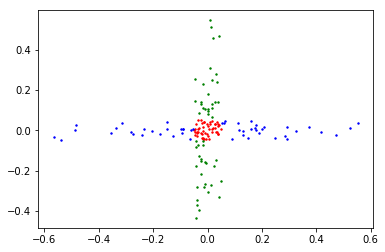

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import winsound
np.set_printoptions(precision=6,suppress=True)
%matplotlib inline
n = 150 # of Patterns (multiple of 3)
patterns = np.zeros([n,5])
count = 0
i=[0,int(n/3),int(2*n/3),int(n)]
sd1=.25
tr=.05
np.random.seed(1234)
def cond(p1,p2,flag): 
    if flag==1: # Normal operating conditions
        return(abs(p1)<tr and abs(p2)<tr)
    elif flag==2: #Type 1 error
        return(abs(p1)>tr and abs(p2)<tr)
    elif flag==3: #Type 2 error
        return(abs(p1)<tr and abs(p2)>tr)
for pos,idx in enumerate(i):
    while count < idx:
        p1 = np.random.normal(0,sd1)
        p2 = np.random.normal(0,sd1)
        if cond(p1,p2,pos):
            patterns[count,0] = p1
            patterns[count,1] = p2
            patterns[count,pos+1] = 1
            count += 1
plt.scatter(patterns[i[0]:i[1],0],patterns[i[0]:i[1],1],c='r',s=2)
plt.scatter(patterns[i[1]:i[2],0],patterns[i[1]:i[2],1],c='b',s=2)
plt.scatter(patterns[i[2]:i[3],0],patterns[i[2]:i[3],1],c='g',s=2)
plt.show()

We said above that the relationship between $(S,tan)$ and $(T,C)$ was "almost" linear. It is not exacly linear because of the absolute value operator on the state variables, due to the +- 0.05 tresholld. So, a correct visualization of the operating conditions on the $(S,tan)$ space is:

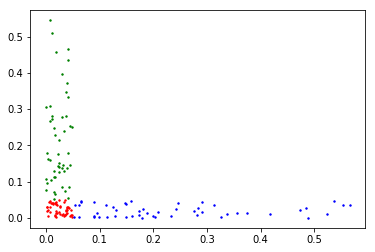

In [19]:
plt.scatter(np.absolute(patterns[i[0]:i[1],0]),np.absolute(patterns[i[0]:i[1],1]),c='r',s=2)
plt.scatter(np.absolute(patterns[i[1]:i[2],0]),np.absolute(patterns[i[1]:i[2],1]),c='b',s=2)
plt.scatter(np.absolute(patterns[i[2]:i[3],0]),np.absolute(patterns[i[2]:i[3],1]),c='g',s=2)
#plt.title("Generational data in the (S,tan) space")
plt.show()

Now, making $x=(T,C)$, we can view our process fault diagnosis chart in the $(T,C)$ space.

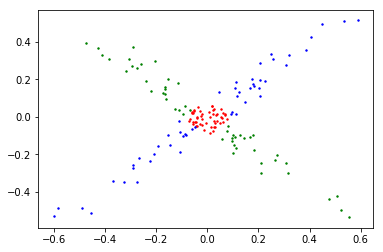

In [3]:
x = np.zeros([n,5])
for idi in range(len(patterns)):
    x[idi,0] = patterns[idi,0] + patterns[idi,1]
    x[idi,1] = patterns[idi,0] - patterns[idi,1]
    x[idi,2:] = patterns[idi,2:]
plt.scatter(x[i[0]:i[1],0],x[i[0]:i[1],1],c='r',s=2)
plt.scatter(x[i[1]:i[2],0],x[i[1]:i[2],1],c='b',s=2)
plt.scatter(x[i[2]:i[3],0],x[i[2]:i[3],1],c='g',s=2)
plt.show()

### Applying ANNs
According to Bengio et al. 2016, one of the modern interpretations of deep learning is that they are a composition of functions. One can interpret any given layer of a neural network as applying a nonlinear transformation $\mathbb{R}^n \rightarrow \mathbb{R}^m$ of the type:
<br><br>
$$Y = f(X)$$
<br><br>
where $X \in \mathbb{R}^n$, $f,Y \in \mathbb{R}^m$ and $f$ is to be found by adaptive learning. So, when you implement many layers of a neural network, you are actually making a composite function $f_1(f_2(f_3(...f_k(x))))$. By analogy, in the classification problem, it's like you are folding the space in many different forms consecutively untill you can properly separate the space in identifiable regions. This is what we will try to accomplish here.

First of all, we train a single hidden layer artificial neural network (will call it MLP from now on). For the sake of data visualization we use only two neurons in the hidden layer in order to plot them on a cartesian plane.

In [4]:
from keras.models import Model
from keras.models import Sequential,load_model
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
import winsound
np.set_printoptions(precision=4,suppress=True)

Using TensorFlow backend.


In [5]:
epocas = 3000

In [6]:
%%time
data = x[:,0:2]
target = x[:,2:]
np.random.seed(321)
model = Sequential()
model.add(Dense(units=2, activation='tanh', input_dim=2,name="l1"))
model.add(Dense(units=3, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
callbacks = ModelCheckpoint('bestfit.hdf5',save_best_only=True)
history = model.fit(data, target, epochs=epocas, batch_size=1,verbose=0,callbacks=[callbacks],validation_data=(data,target))
loss_and_metrics = model.evaluate(data, target)
print(loss_and_metrics)
winsound.Beep(2500,200)

 32/150 [=====>........................] - ETA: 0s[0.75421692291895548, 0.63999999602635704]
Wall time: 14min


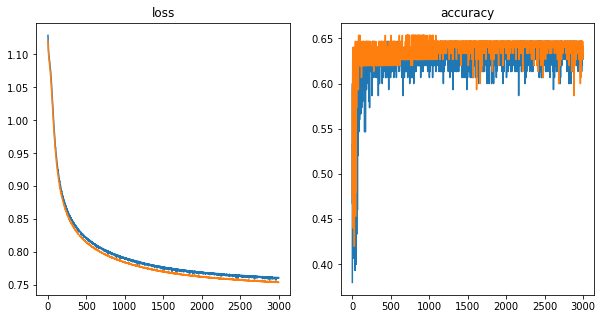

In [7]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title("loss")
ax2.plot(history.history['acc'])
ax2.plot(history.history['val_acc'])
ax2.set_title("accuracy")
plt.show()

In [8]:
from sklearn.metrics import confusion_matrix
modeltemp = load_model('bestfit.hdf5')
evaluation = modeltemp.evaluate(data,target,verbose=0)
print("Error: ",evaluation[0])
print("Accuracy: ",evaluation[1])
y_pred = model.predict(data)
CM = confusion_matrix(np.argmax(target,axis=1),np.argmax(y_pred,axis=1))
print("Confusion C_(i,j) -> i: predicted, j: actual. ")
print(CM)

Error:  0.75416484197
Accuracy:  0.646666662693
Confusion C_(i,j) -> i: predicted, j: actual. 
[[49  1  0]
 [28 22  0]
 [25  0 25]]


Two points are notice worthy:
1. Our intention in this notebook is not to generate the best possible classificator, but to provide insight and visualization of how deep learning can be very useful for process fault identification. On all of our attempts, we will make a restriction that the last hidden layer has only two neurons, so we can plot in a cartesian plane what the artificial intelligence is seeing. In other words, we are internally solving an auto-encoder problem before the classification problem. 
2. We are not using any test set, at least in the beginning, since we intend mostly to extract some insight on the training data itself.
So, to envision how the output layer sees the problem arising from the hidden layer, we plot the latter's outputs. 

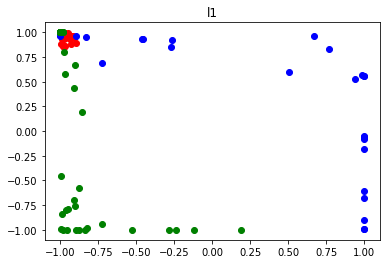

In [9]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
swap = model
model = modeltemp
modeltemp = swap
inter1 = Model(inputs=model.input, outputs=model.get_layer('l1').output)
interout1 = inter1.predict(data)
ax1.plot(interout1[i[0]:i[1],1],interout1[i[0]:i[1],0],'ro',
         interout1[i[1]:i[2],1],interout1[i[1]:i[2],0],'bo',
         interout1[i[2]:i[3],1],interout1[i[2]:i[3],0],'go')
ax1.set_title("l1")
plt.show()

As we can see, it is difficult to correctly distinguish the operation states in such a messy cartesian scatterplot using this nonlinear transformation. Of course we could increase the number of hidden neurons. This would probably render well separated regions in the n-dimensional space as well as provide a good classification. However, this has been done before by the original problem author. Moreover, we will try another approach. Can we add more hidden layers with the smallest possible amount of neurons, while keeping the last hidden layer with only two neurons? So, basically, the idea is to fold the $(T,C)$ space successively untill we can generate a 2D chart of clearly separable regions in the <b>last layer space</b> (LLS).<br>
Our first intuition is to progressively add more hidden layers with only two neurons and see if it can do the job.

First, we try with two hidden layers.

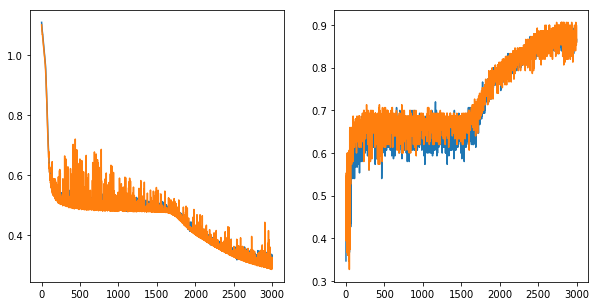

Error:  0.284599225918
Accuracy:  0.906666666667
Confusion C_(i,j) -> i: predicted, j: actual. 
[[32  3 15]
 [ 2 48  0]
 [ 1  0 49]]


In [10]:
np.random.seed(321)
model = Sequential()
model.add(Dense(units=2, activation='tanh', input_dim=2,name="l2"))
model.add(Dense(units=2, activation='tanh',name="l1"))
model.add(Dense(units=3, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
callbacks = ModelCheckpoint('bestfit.hdf5',save_best_only=True)
history = model.fit(data, target, epochs=epocas, batch_size=1,verbose=0,callbacks=[callbacks],validation_data=(data,target))
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax2.plot(history.history['acc'])
ax2.plot(history.history['val_acc'])
plt.show()
modeltemp = load_model('bestfit.hdf5')
evaluation = modeltemp.evaluate(data,target,verbose=0)
print("Error: ",evaluation[0])
print("Accuracy: ",evaluation[1])
y_pred = model.predict(data)
CM = confusion_matrix(np.argmax(target,axis=1),np.argmax(y_pred,axis=1))
print("Confusion C_(i,j) -> i: predicted, j: actual. ")
print(CM)

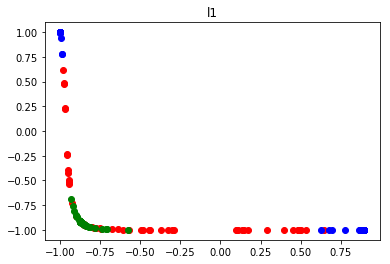

In [11]:
model = modeltemp
inter1 = Model(inputs=model.input, outputs=model.get_layer('l1').output)
interout1 = inter1.predict(data)
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(interout1[i[0]:i[1],1],interout1[i[0]:i[1],0],'ro',
         interout1[i[1]:i[2],1],interout1[i[1]:i[2],0],'bo',
         interout1[i[2]:i[3],1],interout1[i[2]:i[3],0],'go')
ax1.set_title("l1")
plt.show()

We now compare it with a 5 hidden layers deep neural network.

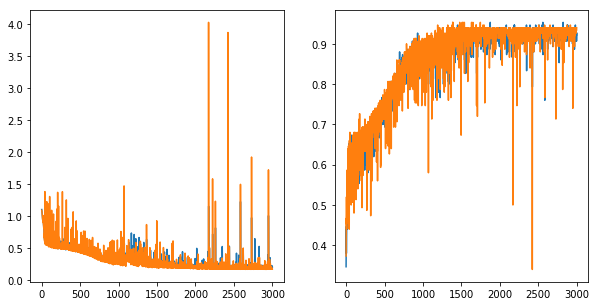

Error:  0.168343398124
Accuracy:  0.946666666667
Confusion C_(i,j) -> i: predicted, j: actual. 
[[50  0  0]
 [ 6 43  1]
 [ 2  0 48]]


In [12]:
np.random.seed(321)
model = Sequential()
model.add(Dense(units=2, activation='tanh', input_dim=2,name="l5"))
model.add(Dense(units=2, activation='tanh',name="l4"))
model.add(Dense(units=2, activation='tanh',name="l3"))
model.add(Dense(units=2, activation='tanh',name="l2"))
model.add(Dense(units=2, activation='tanh',name="l1"))
model.add(Dense(units=3, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
callbacks = ModelCheckpoint('bestfit.hdf5',save_best_only=True)
history = model.fit(data, target, epochs=epocas, batch_size=1,verbose=0,callbacks=[callbacks],validation_data=(data,target))
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax2.plot(history.history['acc'])
ax2.plot(history.history['val_acc'])
plt.show()
modeltemp = load_model('bestfit.hdf5')
evaluation = modeltemp.evaluate(data,target,verbose=0)
print("Error: ",evaluation[0])
print("Accuracy: ",evaluation[1])
y_pred = model.predict(data)
CM = confusion_matrix(np.argmax(target,axis=1),np.argmax(y_pred,axis=1))
print("Confusion C_(i,j) -> i: predicted, j: actual. ")
print(CM)

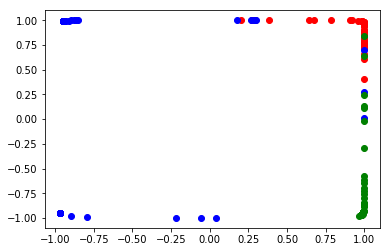

In [13]:
model = modeltemp
inter1 = Model(inputs=model.input, outputs=model.get_layer('l1').output)
inter2 = Model(inputs=model.input, outputs=model.get_layer('l2').output)
inter3 = Model(inputs=model.input, outputs=model.get_layer('l3').output)
inter4 = Model(inputs=model.input, outputs=model.get_layer('l4').output)
interout1 = inter1.predict(data)
interout2 = inter2.predict(data)
interout3 = inter3.predict(data)
interout4 = inter4.predict(data)
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(interout1[i[0]:i[1],1],interout1[i[0]:i[1],0],'ro',
         interout1[i[1]:i[2],1],interout1[i[1]:i[2],0],'bo',
         interout1[i[2]:i[3],1],interout1[i[2]:i[3],0],'go')
plt.show()

As we can see, it is really complicated to separate the categories into visually identifiable regions in the LLS using only two hyperbolic tangent neurons in the hidden layers. We won't add more two neurons layers from here, since we apparently hit a plateau in the ML model performance using this philosofy. We will now take a leap of faith and make some assumptions. 
* First, the scatterplot in the $(T,C)$ space has five different regions, four diagonal and one central. So, in the first layer, we will add five neurons in the hope that this layer can capture this nuance (there is no theoretical basis for this choice whatsoever). 
* Second, these five regions render three different error types. So, we add three neurons in the second layer. (Again, no theoretical basis for this assumption).
* Third, we add the last layer with two neurons to visualize the classification task in the LLS.

At this point, any cognitive machine, or human operator for that matter, can properly classify these three process states using infinite many paths given a plethora of approaches and hyperparameters. But, woudn't it be elegant if our cognitive machine could identify the original error generation in the $(S,tan)$ space?

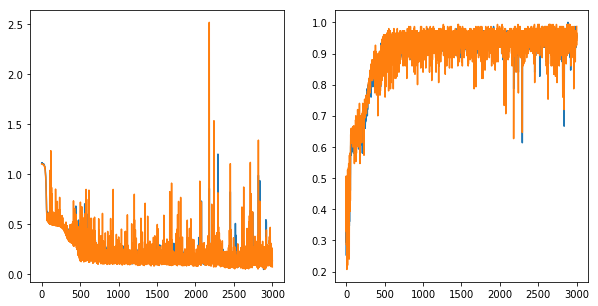

Error:  0.0477586735288
Accuracy:  0.993333333333
Confusion C_(i,j) -> i: predicted, j: actual. 
[[50  0  0]
 [ 1 49  0]
 [ 1  0 49]]
Wall time: 15min


In [21]:
%%time
np.random.seed(2379)
model = Sequential()
model.add(Dense(units=5, activation='tanh', input_dim=2,name="l4"))
model.add(Dense(units=3, activation='tanh',name="l3"))
model.add(Dense(units=2, activation='tanh',name="l2"))
model.add(Dense(units=2, activation='tanh',name="l1"))
model.add(Dense(units=3, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
callbacks = ModelCheckpoint('bestfit.hdf5',save_best_only=True)
history = model.fit(data, target, epochs=epocas, batch_size=1,verbose=0,callbacks=[callbacks],validation_data=(data,target))
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax2.plot(history.history['acc'])
ax2.plot(history.history['val_acc'])
plt.show()
modeltemp = load_model('bestfit.hdf5')
evaluation = modeltemp.evaluate(data,target,verbose=0)
print("Error: ",evaluation[0])
print("Accuracy: ",evaluation[1])
y_pred = model.predict(data)
CM = confusion_matrix(np.argmax(target,axis=1),np.argmax(y_pred,axis=1))
print("Confusion C_(i,j) -> i: predicted, j: actual. ")
print(CM)
winsound.Beep(2500,200)

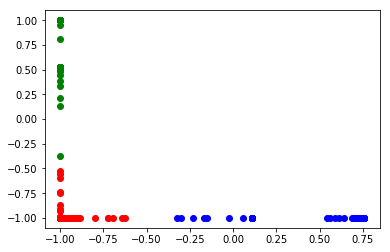

In [22]:
model = modeltemp
inter1 = Model(inputs=model.input, outputs=model.get_layer('l1').output)
inter2 = Model(inputs=model.input, outputs=model.get_layer('l2').output)
inter3 = Model(inputs=model.input, outputs=model.get_layer('l3').output)
interout1 = inter1.predict(data)
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(interout1[i[0]:i[1],1],interout1[i[0]:i[1],0],'ro',
         interout1[i[1]:i[2],1],interout1[i[1]:i[2],0],'bo',
         interout1[i[2]:i[3],1],interout1[i[2]:i[3],0],'go')
#ax1.set_title("l1")
plt.show()

Now, go back in the notebook and look at the "Generational data in the (S,tan) space" plot and see the similarities. Isn't it curious how similar are they?<br><br>
It would be a naïve to argue that the DL model found out the original failure chart by itself, and even removed the noise from the measurements, but the coincidence is amazing. Maybe they are similar due to the simplistic nature of the problem i.e. we designed the problem with very simple linear assumptions and the DL separated the points into three very simple quasi-linear regions.<br><br>
However, one thing we cannot deny is that the DL architecture successfully applied nonlinear transformations to simplify the feature space into clearly separable regions almost exactly over two crossing lines, putting the normal operation points around a pseudo origin. This separation of variables into simple, definite and easily separable regions reflects an increased classification performance, with an increased accuracy and decreased confusion of states.<br><br>
Notice that the difference in performance is not due to an increased number of model parameters, since the 2-2-2-2-2 autoencoder with 64 weights and 10 biases has about the same number of parameters than the 5-3-2 autoencoder with 60 weights and 10 biases.<br><br> One equivalent shallower network with about the same number of parameters is a 15-2 architecture, with 60 weights and 17 biases. 

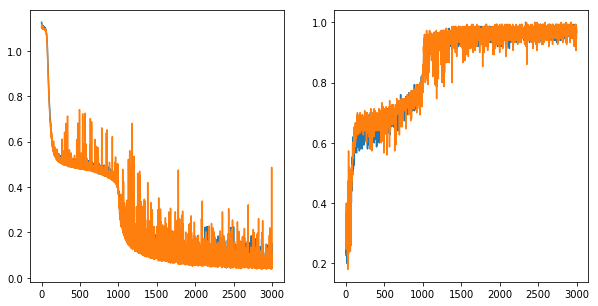

Error:  0.0371669112022
Accuracy:  1.0
Confusion C_(i,j) -> i: predicted, j: actual. 
[[44  0  6]
 [ 2 48  0]
 [ 0  0 50]]


In [16]:
np.random.seed(3345)
model = Sequential()
model.add(Dense(units=15, activation='tanh', input_dim=2,name="l2"))
model.add(Dense(units=2, activation='tanh',name="l1"))
model.add(Dense(units=3, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
callbacks = ModelCheckpoint('bestfit.hdf5',save_best_only=True)
history = model.fit(data, target, epochs=epocas, batch_size=1,verbose=0,callbacks=[callbacks],validation_data=(data,target))
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax2.plot(history.history['acc'])
ax2.plot(history.history['val_acc'])
plt.show()
modeltemp = load_model('bestfit.hdf5')
evaluation = modeltemp.evaluate(data,target,verbose=0)
print("Error: ",evaluation[0])
print("Accuracy: ",evaluation[1])
y_pred = model.predict(data)
CM = confusion_matrix(np.argmax(target,axis=1),np.argmax(y_pred,axis=1))
print("Confusion C_(i,j) -> i: predicted, j: actual. ")
print(CM)
winsound.Beep(2500,200)

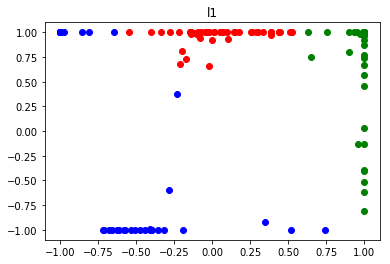

In [17]:
model = modeltemp
inter1 = Model(inputs=model.input, outputs=model.get_layer('l1').output)
inter2 = Model(inputs=model.input, outputs=model.get_layer('l2').output)
interout1 = inter1.predict(data)
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(interout1[i[0]:i[1],1],interout1[i[0]:i[1],0],'ro',
         interout1[i[1]:i[2],1],interout1[i[1]:i[2],0],'bo',
         interout1[i[2]:i[3],1],interout1[i[2]:i[3],0],'go')
ax1.set_title("l1")
plt.show()

This archiitecture renders a nice 2D plot, with visually clear separable regions. However, it did not give us a plot that seemingly approaches the original generational data in the $(S,tan)$ space. The classification performance is also a little worst than the 5-3-2 architecture, but we should carry out a thorough hyperparameter optimization work, with cross validation, if we are to declare any winner.<br><br> However, we do assert that after several attempts to train this network, none of them rendered a LLS plot even close to the generational data plot. So, we might use this information to infer that the 5-3-2 deeper architecture may actually be somehow performing three different transformations on the dataset; rotation, squashing and axial fold. Once again, this is not a thorough analisys of the inner workings of ANNs, but rather a visual interpretation of the usefullness behind using deeper ANN architectures rather than wider ones, for the purposes of foult detection and diagnosis in chemical engneering.

### In practice the theory is very different
The above description of our problem a much idealized condition. In real life, however, any measurement is subject to random noise. In our case, the main source of noise arises from the instruments i.e. the thermometer and the densimeter (yes, we mostly read alcohol concentration by its density). (To be continued...)